In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [2]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [3]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


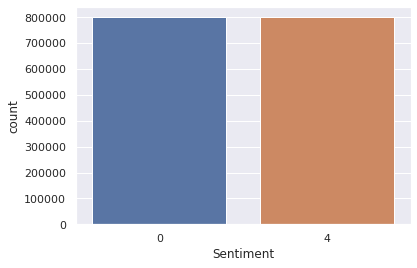

In [4]:
sns.countplot(df.Sentiment)

In [5]:
df['Sentiment'] = df.Sentiment.replace(4,1)

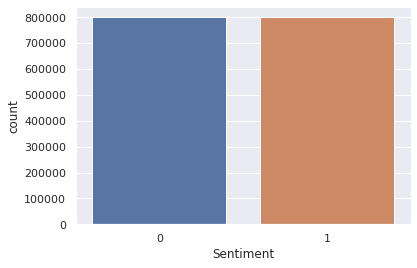

In [6]:
sns.countplot(df.Sentiment)

In [7]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

In [8]:
df['Tweet'] = df.Tweet.apply(process_text)

In [9]:
df.head()

,Sentiment,Tweet
0,0,"entity - awww, that's a bummer. you shoulda ..."
1,0,is upset that he can't update his facebook by ...
2,0,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"entity no, it's not behaving at all. i'm mad. ..."


In [10]:
labels = df.Sentiment.values
text = df.Tweet.values

In [11]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [13]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [15]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1280000
Validation Size -  320000


In [16]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)

In [17]:
len(train_dl),len(val_dl)

(40000, 10000)

In [18]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [21]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

In [22]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [23]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [24]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


In [ ]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

In [ ]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)


In [ ]:
ans = Sentiment('i want to die')

In [ ]:
if ans == 1:
    print("Positive")
else:
    print("Negative")

In [ ]:
ans = Sentiment('I bought a phone, battery is very good, screen resulation is exceptional, but it is little heavy. However it does not matter to me. It is very good product.')

In [ ]:
if ans == 1:
    print("Positive")
else:
    print("Negative")